In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import R2Score

In [2]:
num_epochs = 500
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [3]:
initialize=True

In [4]:
df = pd.read_csv('./united_data_soybean.csv', index_col=0).fillna(0)
y = df['Soybean_Yield']
X = df.drop(columns=['Soybean_Yield'], axis=1)

In [9]:
y = pd.DataFrame(y)
def convert_corn_yield(row):
    idx = row.name
    year = int(idx[:4])
    row['Soybean_Yield'] = row['Soybean_Yield'] + (1950-year)*0.47105142
    return row
    

In [10]:
y = y.apply(convert_corn_yield, axis=1)
y = y['Soybean_Yield']

In [11]:
correct = y[y>10].index

In [12]:
y = y[correct]
X = X.loc[correct]

In [13]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [15]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [16]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)


In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [18]:
model = LSTM(input_size, hidden_size, num_layers)
weather_test = X_test.reshape(-1, sequence_length, input_size)
weather_train = X_train.reshape(-1, sequence_length, input_size)
print(weather_test.shape)
print(weather_train.shape)

torch.Size([182, 4, 222])
torch.Size([546, 4, 222])


## Train the model

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
train_losses = []
test_losses = []
min_test_loss = 9999999

r2score = R2Score()
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs.reshape(-1), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            outputs = model(weather_train)
            loss_train = criterion(outputs.reshape(-1), y_train)
            outputs = model(weather_test)
            loss_test = criterion(outputs.reshape(-1), y_test)
            train_losses.append(loss_train)
            test_losses.append(loss_test)

            rscore = r2score(outputs.reshape(-1), y_test)
            if loss_test < min_test_loss:
                torch.save(model.state_dict(), "lstm-adjusted-corrected-500-soy")
            print("Epoch: ", epoch + 1, " Train loss: ", loss_train.item(), "Test loss:", loss_test.item(), "Test R-squared:", rscore.item())

Epoch:  1  Train loss:  28.148767471313477 Test loss: 24.64427375793457 Test R-squared: 0.07457178831100464
Epoch:  2  Train loss:  22.59721565246582 Test loss: 19.530536651611328 Test R-squared: 0.26660001277923584
Epoch:  3  Train loss:  21.09473419189453 Test loss: 15.779488563537598 Test R-squared: 0.40745729207992554
Epoch:  4  Train loss:  20.916173934936523 Test loss: 16.09813117980957 Test R-squared: 0.3954918384552002
Epoch:  5  Train loss:  19.679426193237305 Test loss: 12.823450088500977 Test R-squared: 0.5184608697891235
Epoch:  6  Train loss:  20.25264549255371 Test loss: 12.525991439819336 Test R-squared: 0.5296308398246765
Epoch:  7  Train loss:  20.042766571044922 Test loss: 12.157964706420898 Test R-squared: 0.5434508323669434
Epoch:  8  Train loss:  18.83744239807129 Test loss: 11.217270851135254 Test R-squared: 0.5787752270698547
Epoch:  9  Train loss:  20.871740341186523 Test loss: 11.640210151672363 Test R-squared: 0.5628932118415833
Epoch:  10  Train loss:  19.101

In [21]:
outputs = model(weather_test)
rscore = r2score(outputs.reshape(-1), y_test)
rscore.item()

0.9535692930221558

In [26]:
loss_test.item()

1.2364550828933716

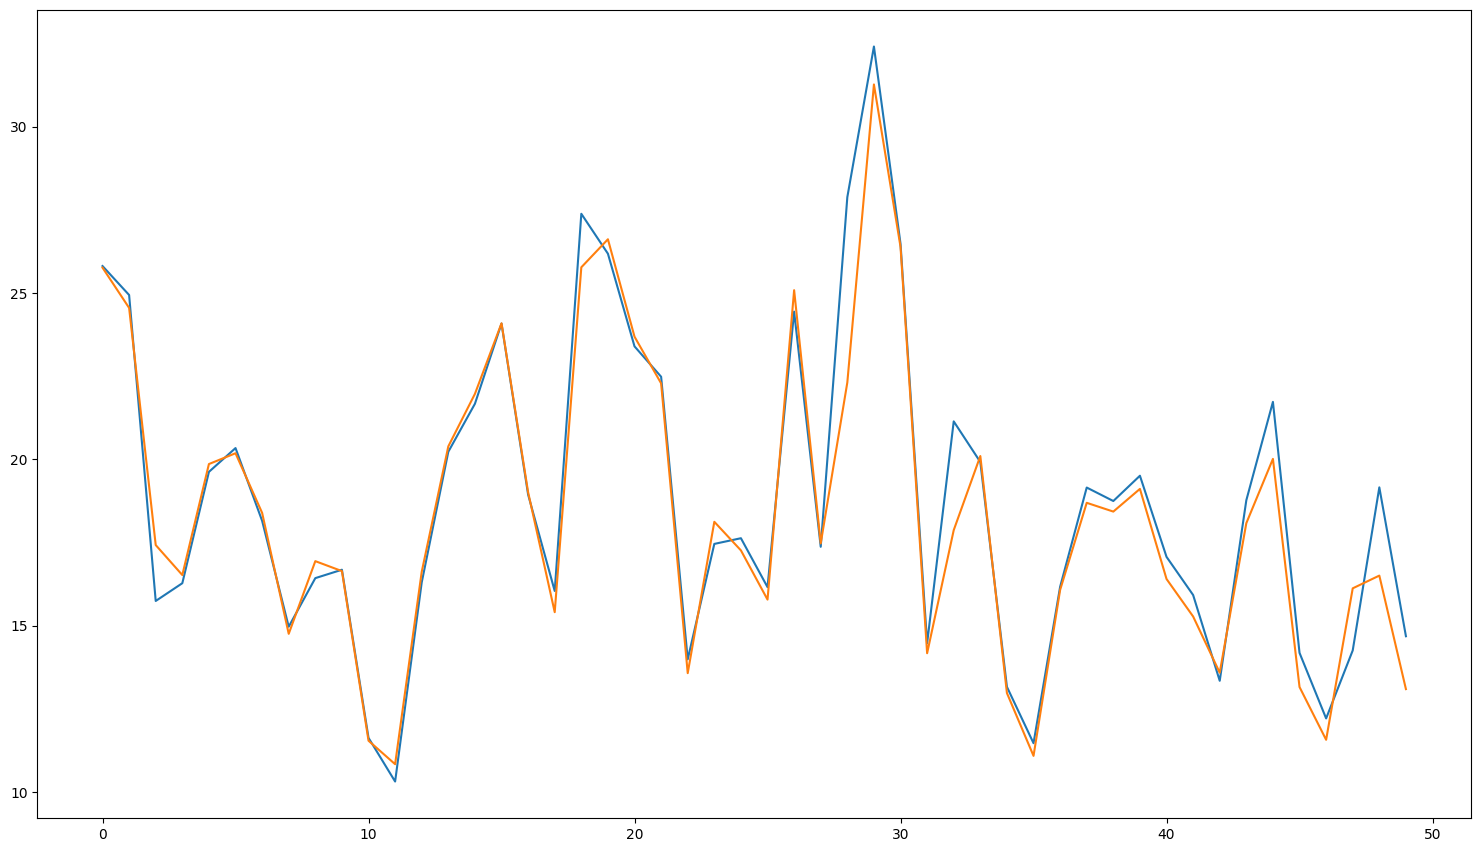

In [22]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Load and evaluate the model

In [13]:
from utils import get_data_pred

model.load_state_dict(torch.load("lstm-adjusted-500"))
out = get_data_pred('ACAvNTuEuFWcmwms', model, adjust=True, crop='corn')
out

(tensor([[ 75.3805],
         [ 75.4429],
         [129.0984],
         [139.2952],
         [128.8876],
         [133.1449],
         [144.2295],
         [164.3298],
         [129.8442],
         [151.6084],
         [140.4799],
         [149.0764],
         [149.4333],
         [154.5029],
         [150.9960],
         [107.0173],
         [137.2893]]),
 2006,
 2022)

In [222]:
# outputs # of the model we trained without the adjustments

tensor([[100.2934],
        [ 96.1967],
        [ 95.1817],
        [112.0884],
        [ 98.1280],
        [ 88.9596],
        [156.1279],
        [137.4307],
        [ 74.4149],
        [108.9806],
        [119.3128],
        [126.0991],
        [127.9114],
        [104.2989],
        [106.2627],
        [154.4127],
        [ 77.3407]], grad_fn=<AddmmBackward0>)

In [16]:
out # oof the model we trained with the adjustments

tensor([[114.4748],
        [ 63.8450],
        [124.6391],
        [138.7735],
        [141.8226],
        [141.1663],
        [148.0757],
        [131.5047],
        [132.3883],
        [155.8086],
        [149.0855],
        [144.8992],
        [136.4871],
        [154.3260],
        [161.6747],
        [110.9454],
        [144.0197]])

### Plot the loss

In [23]:
res = pd.DataFrame(data=np.asarray([train_losses, test_losses])).transpose()
res.columns = ['Train loss','Test loss']

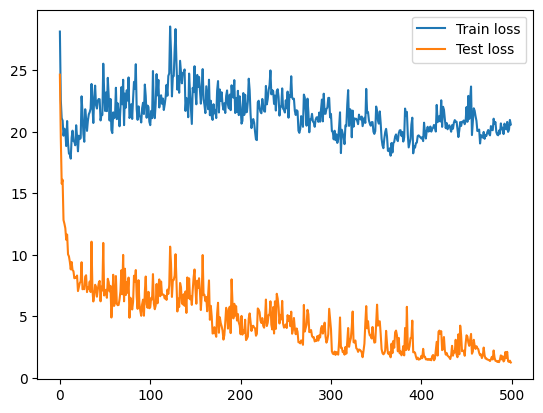

In [24]:
import matplotlib.pyplot as plt
res.plot()
plt.savefig('lstm-adjusted-500-losses.png')

<Axes: >

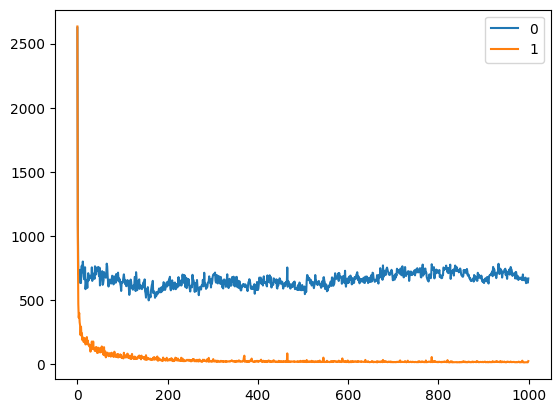

In [72]:
# res.plot() # training without adjustments 

In [14]:
from os import listdir
from os.path import isfile, join
mypath = "../data/weather/prediction_targets_daily/"
filenames = [f[:16] for f in listdir(mypath) if isfile(join(mypath, f))]

In [15]:
import tqdm
preds = []
for filename in tqdm.tqdm(filenames):
    pred, first_year, last_year = get_data_pred(filename, model, adjust=True, crop='corn')
    years = [x for x in range(first_year, last_year + 1)]
    ret = []
    for i in range(len(years)):
        ret.append([years[i], pred[i].item()])
    preds.append(ret)

100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [02:23<00:00,  1.38it/s]


In [16]:
preds

[[[2006, 75.38052368164062],
  [2007, 75.44285583496094],
  [2008, 129.09841918945312],
  [2009, 139.29519653320312],
  [2010, 128.88755798339844],
  [2011, 133.14491271972656],
  [2012, 144.22946166992188],
  [2013, 164.32981872558594],
  [2014, 129.84420776367188],
  [2015, 151.6083526611328],
  [2016, 140.4799346923828],
  [2017, 149.076416015625],
  [2018, 149.43331909179688],
  [2019, 154.5028839111328],
  [2020, 150.9959716796875],
  [2021, 107.01734924316406],
  [2022, 137.289306640625]],
 [[1973, 81.39659881591797],
  [1974, 69.02253723144531],
  [1975, 58.75933837890625],
  [1976, 98.06024932861328],
  [1977, 112.82048034667969],
  [1978, 89.55804443359375],
  [1979, 73.66434478759766],
  [1980, 82.35321044921875],
  [1981, 99.81375885009766],
  [1982, 100.72946166992188],
  [1983, 90.57649993896484],
  [1984, 88.26078796386719],
  [1985, 106.7789077758789],
  [1986, 105.91160583496094],
  [1987, 117.54984283447266],
  [1988, 84.27842712402344],
  [1989, 96.68414306640625],
  

In [17]:
data = []
for i in range(len(filenames)):
    for p in preds[i]:
        data.append([filenames[i], str(p[0]), "Corn, Grain", p[1]])

In [18]:
pd.DataFrame(data, columns=["Target location","Year","Crop","Predicted yield (BUacre)"]).to_csv('corn_predicts.csv', index=False)

In [35]:
pd.DataFrame(data, columns=["Target location","Year","Crop","Predicted yield (BUacre)"])

,Target location,Year,Crop,Predicted yield (BUacre)
0,zuWktVTnYICcsVFr,2006,Corn Grain,75.380524
1,zuWktVTnYICcsVFr,2007,Corn Grain,75.442856
2,zuWktVTnYICcsVFr,2008,Corn Grain,129.098419
3,zuWktVTnYICcsVFr,2009,Corn Grain,139.295197
4,zuWktVTnYICcsVFr,2010,Corn Grain,128.887558
...,...,...,...,...
5070,zuWktVTnYICcsVFr,2018,Corn Grain,185.572479
5071,zuWktVTnYICcsVFr,2019,Corn Grain,190.961899
5072,zuWktVTnYICcsVFr,2020,Corn Grain,193.695724
5073,zuWktVTnYICcsVFr,2021,Corn Grain,200.901413


In [23]:
years

[]

In [29]:
data

[['zuWktVTnYICcsVFr,2006', 'Corn Grain', 75.38052368164062],
 ['zuWktVTnYICcsVFr,2007', 'Corn Grain', 75.44285583496094],
 ['zuWktVTnYICcsVFr,2008', 'Corn Grain', 129.09841918945312],
 ['zuWktVTnYICcsVFr,2009', 'Corn Grain', 139.29519653320312],
 ['zuWktVTnYICcsVFr,2010', 'Corn Grain', 128.88755798339844],
 ['zuWktVTnYICcsVFr,2011', 'Corn Grain', 133.14491271972656],
 ['zuWktVTnYICcsVFr,2012', 'Corn Grain', 144.22946166992188],
 ['zuWktVTnYICcsVFr,2013', 'Corn Grain', 164.32981872558594],
 ['zuWktVTnYICcsVFr,2014', 'Corn Grain', 129.84420776367188],
 ['zuWktVTnYICcsVFr,2015', 'Corn Grain', 151.6083526611328],
 ['zuWktVTnYICcsVFr,2016', 'Corn Grain', 140.4799346923828],
 ['zuWktVTnYICcsVFr,2017', 'Corn Grain', 149.076416015625],
 ['zuWktVTnYICcsVFr,2018', 'Corn Grain', 149.43331909179688],
 ['zuWktVTnYICcsVFr,2019', 'Corn Grain', 154.5028839111328],
 ['zuWktVTnYICcsVFr,2020', 'Corn Grain', 150.9959716796875],
 ['zuWktVTnYICcsVFr,2021', 'Corn Grain', 107.01734924316406],
 ['zuWktVTnYICcs